# Feature Engneering Project

### Data Description:
The actual concrete compressive strength (MPa) for a given mixture under aspecific age (days) was determined from laboratory. Data is in raw form (not scaled). The data has 8 quantitative input variables, and 1 quantitative output
variable, and 1030 instances (observations).

### Domain:
Cement manufacturing

### Attribute Information:
* Cement : measured in kg in a m3 mixture
* Blast : measured in kg in a m3 mixture
* Fly ash : measured in kg in a m3 mixture
* Water : measured in kg in a m3 mixture
* Superplasticizer : measured in kg in a m3 mixture
* Coarse Aggregate : measured in kg in a m3 mixture
* Fine Aggregate : measured in kg in a m3 mixture
* Age : day (1~365)
* Concrete compressive strength measured in MPa

### Objective:
Modeling of strength of high performance concrete using Machine Learning

### 1. Import the Libraries

In [60]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; sns.set_style(style='darkgrid')
from collections import OrderedDict

%matplotlib inline

# Checking multicollinearity

from patsy import dmatrices

# Cluster analysis
from sklearn.cluster import KMeans

# Feature importance
import eli5
from eli5.sklearn import PermutationImportance

# Modelling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.svm import SVR
import xgboost as xgb

# Metrics
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.utils import resample

# Display settings
pd.options.display.max_rows = 400
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format

random_state = 2019
np.random.seed(random_state)

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

### 2. Load the dataset

In [2]:
#Read the data as 'Data' dataframe
Data = pd.read_csv('concrete.csv')

In [3]:
#Reading the first five rows of dataset
Data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,29.89
1,168.90,42.20,124.30,158.30,10.80,1080.80,796.20,14,23.51
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,29.22
3,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28,45.85
4,154.80,183.40,0.00,193.30,9.10,1047.40,696.70,28,18.29


In [4]:
#last 5 rows using tail() function
Data.tail()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
1025,135.00,0.00,166.00,180.00,10.00,961.00,805.00,28,13.29
1026,531.30,0.00,0.00,141.80,28.20,852.10,893.70,3,41.30
1027,276.40,116.00,90.30,179.60,8.90,870.10,768.30,28,44.28
1028,342.00,38.00,0.00,228.00,0.00,932.00,670.00,270,55.06
1029,540.00,0.00,0.00,173.00,0.00,1125.00,613.00,7,52.61


* All the columns seem to be numeric, although not necesarily continuous
* Let's check the datatypes, shape and number of missing values in the dataframe to see if there are read as numerical attributes

### 3. Data Preprocessing

In [5]:
#checking the shape of dataset. Dataset having 846 rows and 19 columns.
Data.shape

(1030, 9)

In [6]:
#To show the detailed summary
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [7]:
#To get the number of columns
Data.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

In [8]:
col = Data.columns[Data.isnull().any()]
Data.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.00,281.17,104.51,102.00,192.38,272.90,350.00,540.00
slag,1030.00,73.90,86.28,0.00,0.00,22.00,142.95,359.40
ash,1030.00,54.19,64.00,0.00,0.00,0.00,118.30,200.10
water,1030.00,181.57,21.35,121.80,164.90,185.00,192.00,247.00
superplastic,1030.00,6.20,5.97,0.00,0.00,6.40,10.20,32.20
coarseagg,1030.00,972.92,77.75,801.00,932.00,968.00,1029.40,1145.00
fineagg,1030.00,773.58,80.18,594.00,730.95,779.50,824.00,992.60
age,1030.00,45.66,63.17,1.00,7.00,28.00,56.00,365.00
strength,1030.00,35.82,16.71,2.33,23.71,34.45,46.14,82.60


* cement: Data ranges between 102 to 540, while 25th and 75th percentile is spread between 192.38 to 350. Median (272.90) is less than Mean (281.17) which means cement is moderately skewed to the right. Column has no outliers.
* slag: Data ranges between 0 to 359.40, while 25th and 75th percentile is spread between 0 to 142.95. Median (22) is less than Mean (73.90) which means slag is moderately skewed to the right. Column has outliers.
* ash: Data ranges between 0 to 200.10, while 25th and 75th percentile is spread between 0 to 118.30. Median (0) is less than Mean (54.19) which mean ash is moderately skewed to the right. Column has no outliers.
* water: Data ranges between 121.80 to 247, while 25th and 75th percentile is spread between 164.90 and 192. Median (185) is greater than Mean (181.57) which means water is skewed to the left (fairly sym). Column has outliers.
* superplastic: Data ranges between 0 to 32.20, while 25th and 75th percentile is spread between 0 to 10.20. Median (6.40) is greater than Mean (6.20) which means superplastic is moderately skewed to the left. Column has outliers.
* coarseagg: Data ranges between 801 to 1145, while 25th and 75th percentile is spread between 932 to 1029.40. Median (968) is less than Mean (972.92) which means coarseagg is skewed to the right (fairly sym). Column has no outliers.
* fineagg: Data ranges between 594 to 992.60, while 25th and 75th percentile is spread between 730.95 to 824. Median (779.5) is greater than Mean (773.58) which means fineagg is skewed to the left (fairly sym). Column has no outliers.
* age: Data ranges between 1 to 365, while 25th and 75th percentile is spread between 7 to 56. Median (28) is less than Mean (45.66) which means age is highly skewed to the right. Column has no outliers.
* strength: Data ranges between 2.33 to 82.60, while 25th and 75th percentile is spread between 23.71 to 46.14. Median (34.45) is less than Mean (35.82) which means strength is slightly skewed to the right (fairly sym). Column has no outliers.

It gives the descriptive statistics (mean, median, mode, percentiles, min, max, standard deviation) of the columns of the dataset.

#### Checking Missing Value

In [9]:
# Checking Missing value present in the dataset. It seems that datset is having no missing value
Data.apply(lambda x : sum(x.isnull()))

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

#### Correlation Matrix
* From the observation of Correction map, we cannot see any strong corelation between all atrributes.

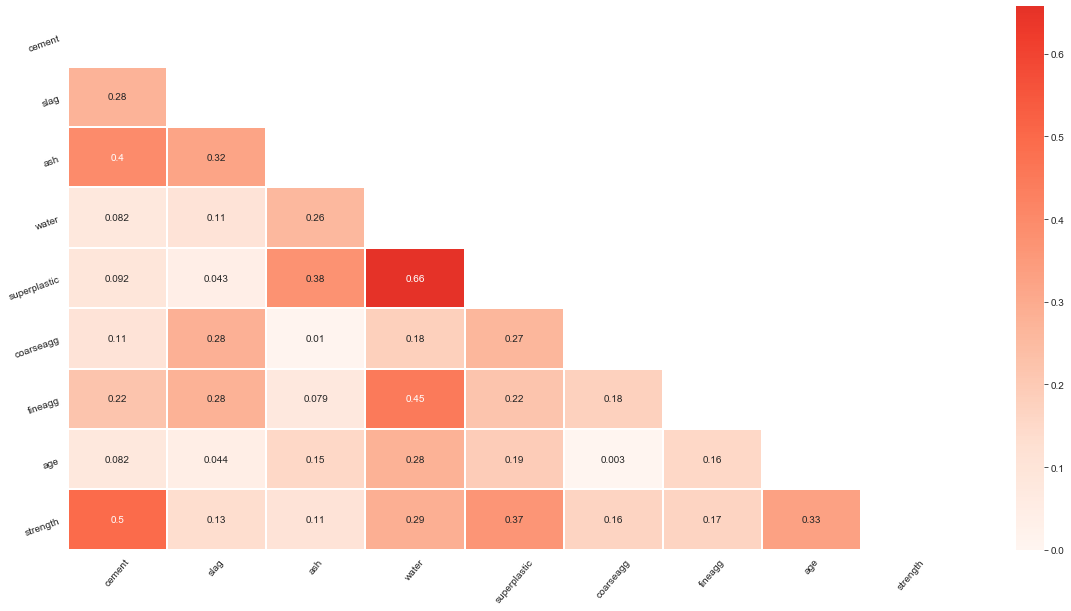

In [10]:
corr = abs(Data.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (20,10))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Reds', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= True, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

### Univariate analysis

In [11]:
# Functions that will help us with EDA plot
def odp_plots(Data, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = Data, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(Data[col], ax = ax2, color = 'teal', fit = norm, rug = True).set_title(f'{col} with outliers')
    ax2.axvline(Data[col].mean(), color = 'r', linestyle = '--', label = 'Mean', linewidth = 1.2)
    ax2.axvline(Data[col].median(), color = 'g', linestyle = '--', label = 'Median', linewidth = 1.2)
    ax2.axvline(Data[col].mode()[0], color = 'b', linestyle = '--', label = 'Mode', linewidth = 1.2); ax2.legend(loc = 'best')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(Data[col], [1, 99])
    y = pd.DataFrame(np.clip(Data[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm, rug = True).set_title(f'{col} without outliers')
    ax3.axvline(y[col].mean(), color = 'r', linestyle = '--', label = 'Mean', linewidth = 1.2)
    ax3.axvline(y[col].median(), color = 'g', linestyle = '--', label = 'Median', linewidth = 1.2)
    ax3.axvline(y[col].mode()[0], color = 'b', linestyle = '--', label = 'Mode', linewidth = 1.2); ax3.legend(loc = 'best')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

Box plot, distribution of columns with and without outliers

Cement column
Number of rows with outliers: 0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength


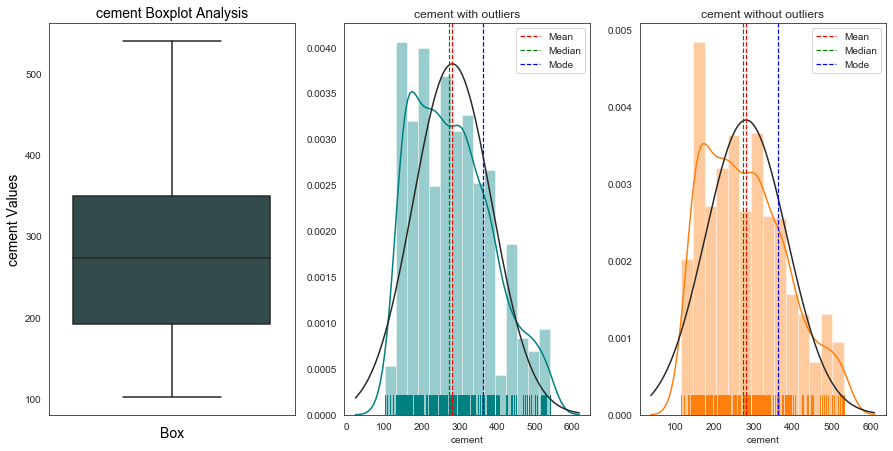

Slag column
Number of rows with outliers: 2


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.60,359.40,0.00,185.70,0.00,941.60,664.30,28,39.44
990,239.60,359.40,0.00,185.70,0.00,941.60,664.30,7,25.42


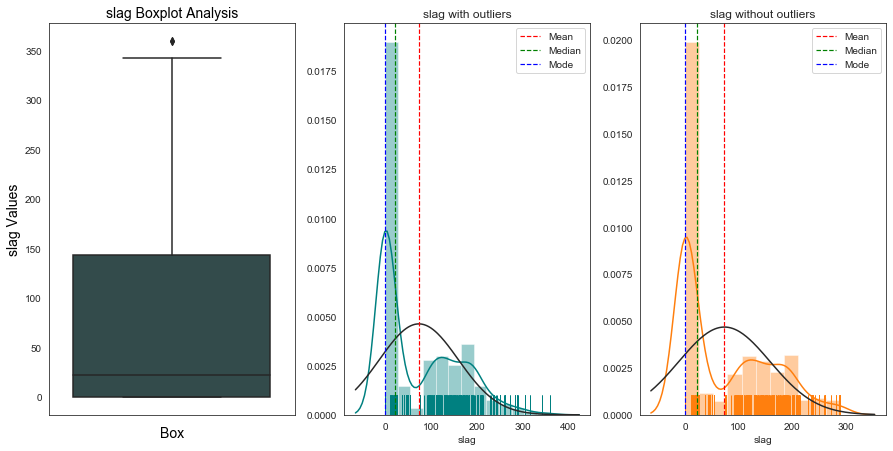

Ash column
Number of rows with outliers: 0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength


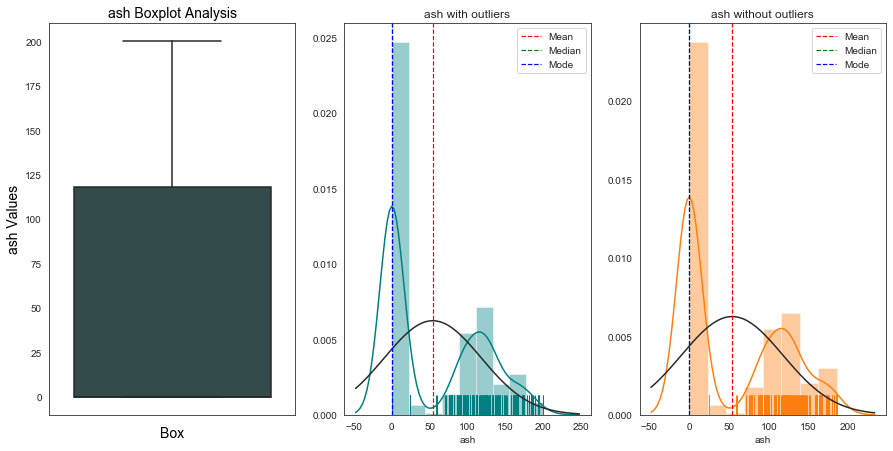

Water column
Number of rows with outliers: 9


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.00,92.00,71.00,247.00,6.00,853.00,695.00,28,28.63
263,236.90,91.70,71.50,246.90,6.00,852.90,695.40,28,28.63
432,168.00,42.10,163.80,121.80,5.70,1058.70,780.10,28,24.24
462,168.00,42.10,163.80,121.80,5.70,1058.70,780.10,100,39.23
587,168.00,42.10,163.80,121.80,5.70,1058.70,780.10,3,7.75


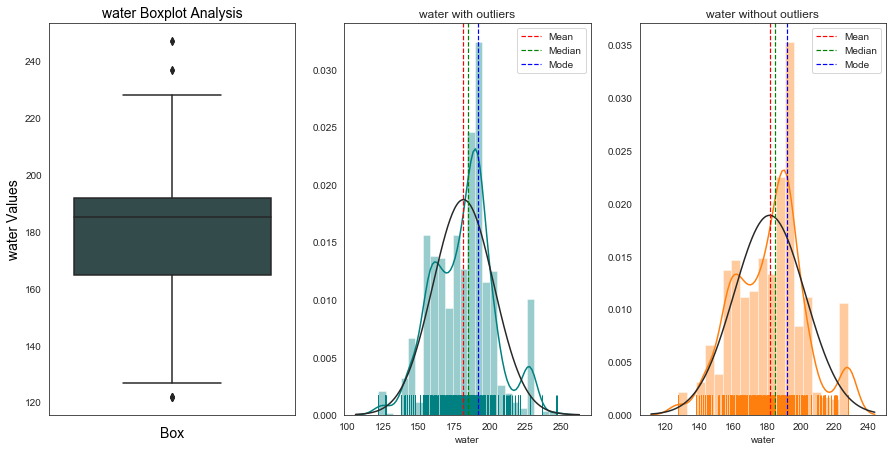

Superplastic column
Number of rows with outliers: 10


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.30,0.00,0.00,141.80,28.20,852.10,893.70,91,59.20
156,531.30,0.00,0.00,141.80,28.20,852.10,893.70,28,56.40
232,469.00,117.20,0.00,137.80,32.20,852.10,840.50,56,69.30
292,469.00,117.20,0.00,137.80,32.20,852.10,840.50,91,70.70
538,531.30,0.00,0.00,141.80,28.20,852.10,893.70,7,46.90


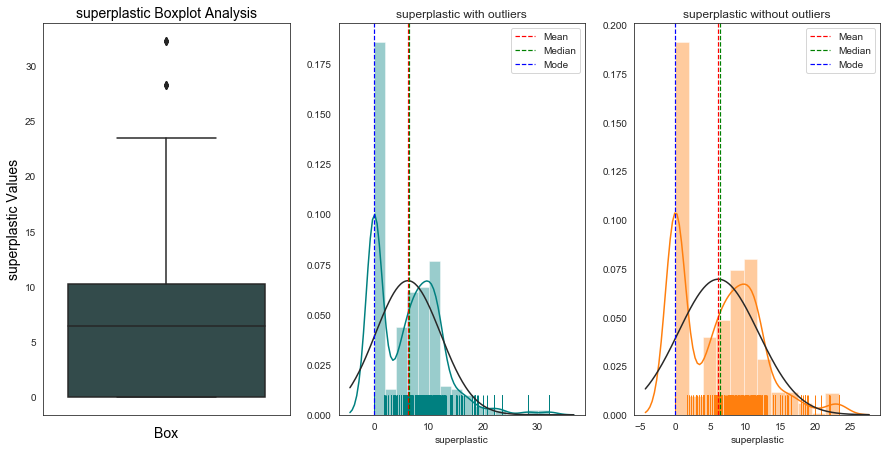

Coarseagg column
Number of rows with outliers: 0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength


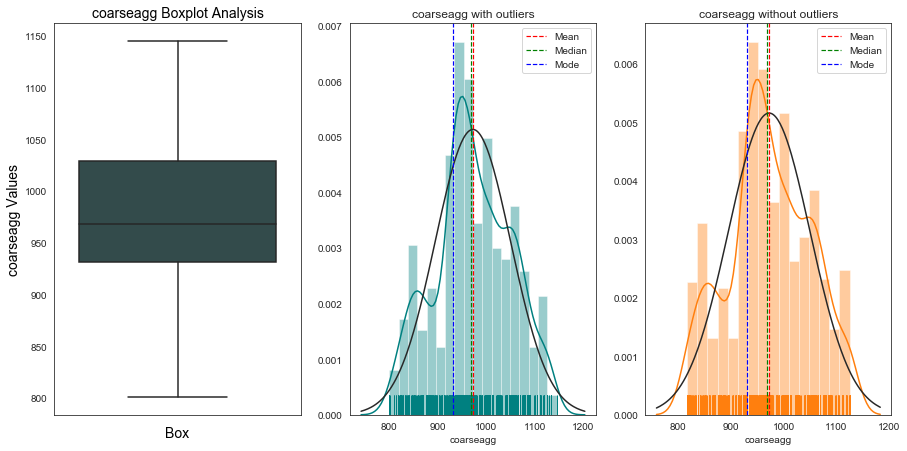

Fineagg column
Number of rows with outliers: 5


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.00,93.80,0.00,126.60,23.40,852.10,992.60,91,62.50
447,375.00,93.80,0.00,126.60,23.40,852.10,992.60,7,45.70
504,375.00,93.80,0.00,126.60,23.40,852.10,992.60,3,29.00
584,375.00,93.80,0.00,126.60,23.40,852.10,992.60,56,60.20
857,375.00,93.80,0.00,126.60,23.40,852.10,992.60,28,56.70


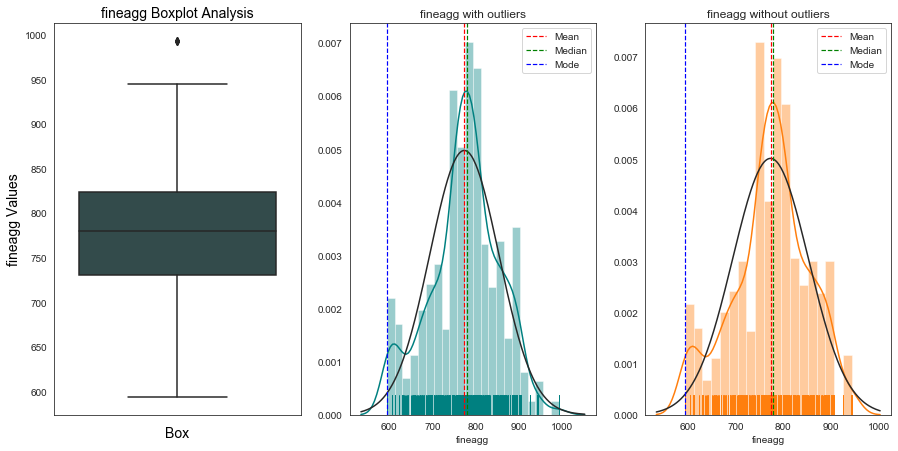

Age column
Number of rows with outliers: 59


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.00,0.00,0.00,192.00,0.00,978.00,825.00,180,39.00
64,332.50,142.50,0.00,228.00,0.00,932.00,594.00,365,41.05
93,427.50,47.50,0.00,228.00,0.00,932.00,594.00,180,41.84
99,237.50,237.50,0.00,228.00,0.00,932.00,594.00,180,36.25
103,380.00,0.00,0.00,228.00,0.00,932.00,670.00,180,53.10


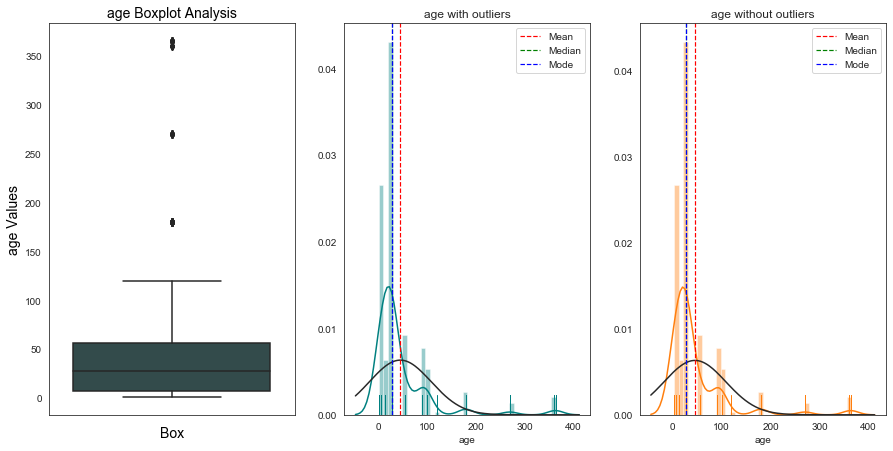

In [12]:
# Outlier, distribution for columns with outliers
print('Box plot, distribution of columns with and without outliers'); print('')

boxplotcolumns = list(Data.columns)[:-1]
for cols in boxplotcolumns:
    Q3 = Data[cols].quantile(0.75)
    Q1 = Data[cols].quantile(0.25)
    IQR = Q3 - Q1

    print(f'{cols.capitalize()} column')
    print(f'Number of rows with outliers: {len(Data.loc[(Data[cols] < (Q1 - 1.5 * IQR)) | (Data[cols] > (Q3 + 1.5 * IQR))])}')
    display(Data.loc[(Data[cols] < (Q1 - 1.5 * IQR)) | (Data[cols] > (Q3 + 1.5 * IQR))].head())
    odp_plots(Data, cols)

del cols, IQR, boxplotcolumns

### Multivariate Analysis

### Distribution of Features:
* Distribution of attributes (cement, coarseagg, fineagg, strength) are fairly normal.
* Attributes slag, ash, superplastic,age are right skewed.
* Attributes water left skewed.
* Removing the outliers of these highly skewed features may affect the nature of distribution.

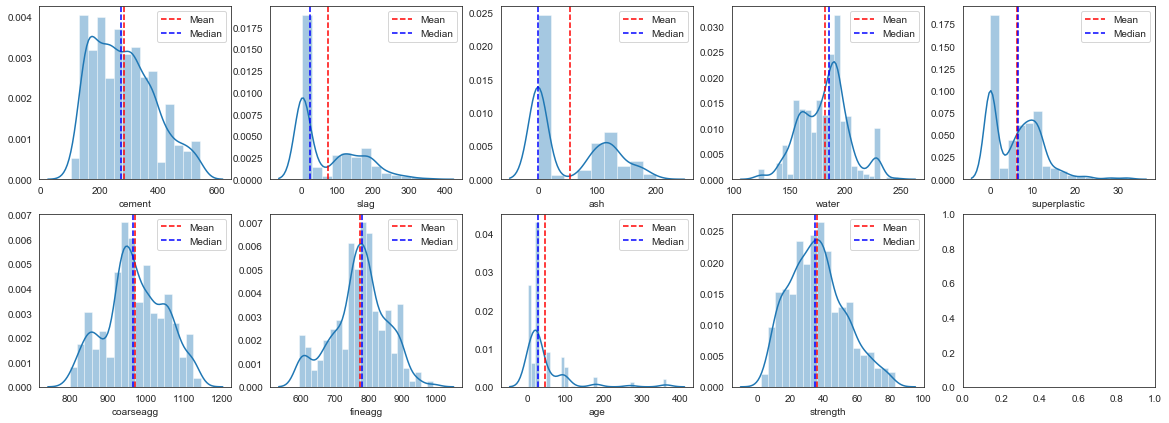

In [13]:
Data1 = Data.copy(deep =True)
fix, ax = plt.subplots(nrows = 2, ncols = 5, figsize = [20, 7])
columns = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'] 
for col, axes in zip(columns, ax.flatten()):
  sns.distplot(Data[col], ax = axes)
  mean = Data[col].mean()
  median = Data[col].median()
  axes.axvline(mean, color = 'r', linestyle = '--') # Vertical line along axis to indicate the mean
  axes.axvline(median, color = 'b', linestyle = '--') # Vertical line to indicate the median
  axes.legend({'Mean': mean, 'Median': median})

### Understanding the outier using boxplot

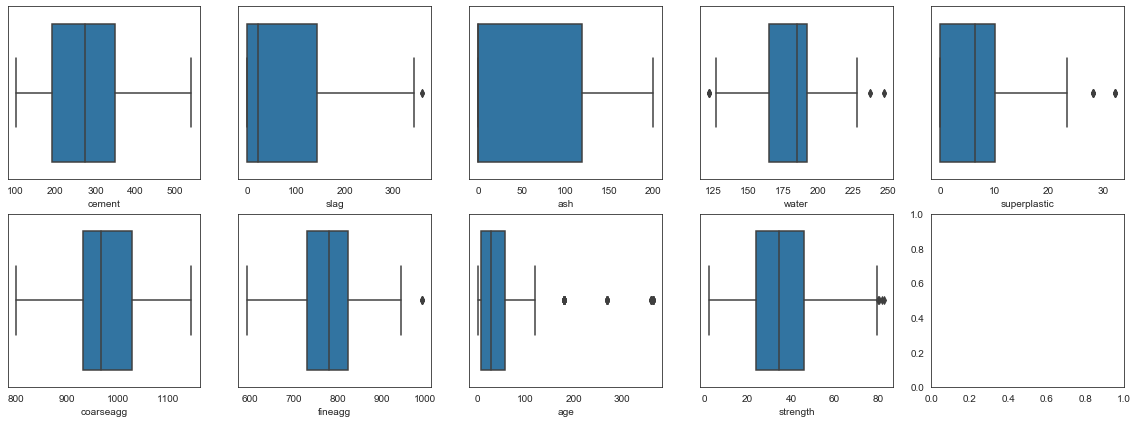

In [14]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = [20, 7])

for col, axes in zip(columns, ax.flatten()):
  sns.boxplot(Data[col], ax = axes)

* We can obseved that 'slag','water', 'superplastic','fineagg','age','strength' attributes having outlier

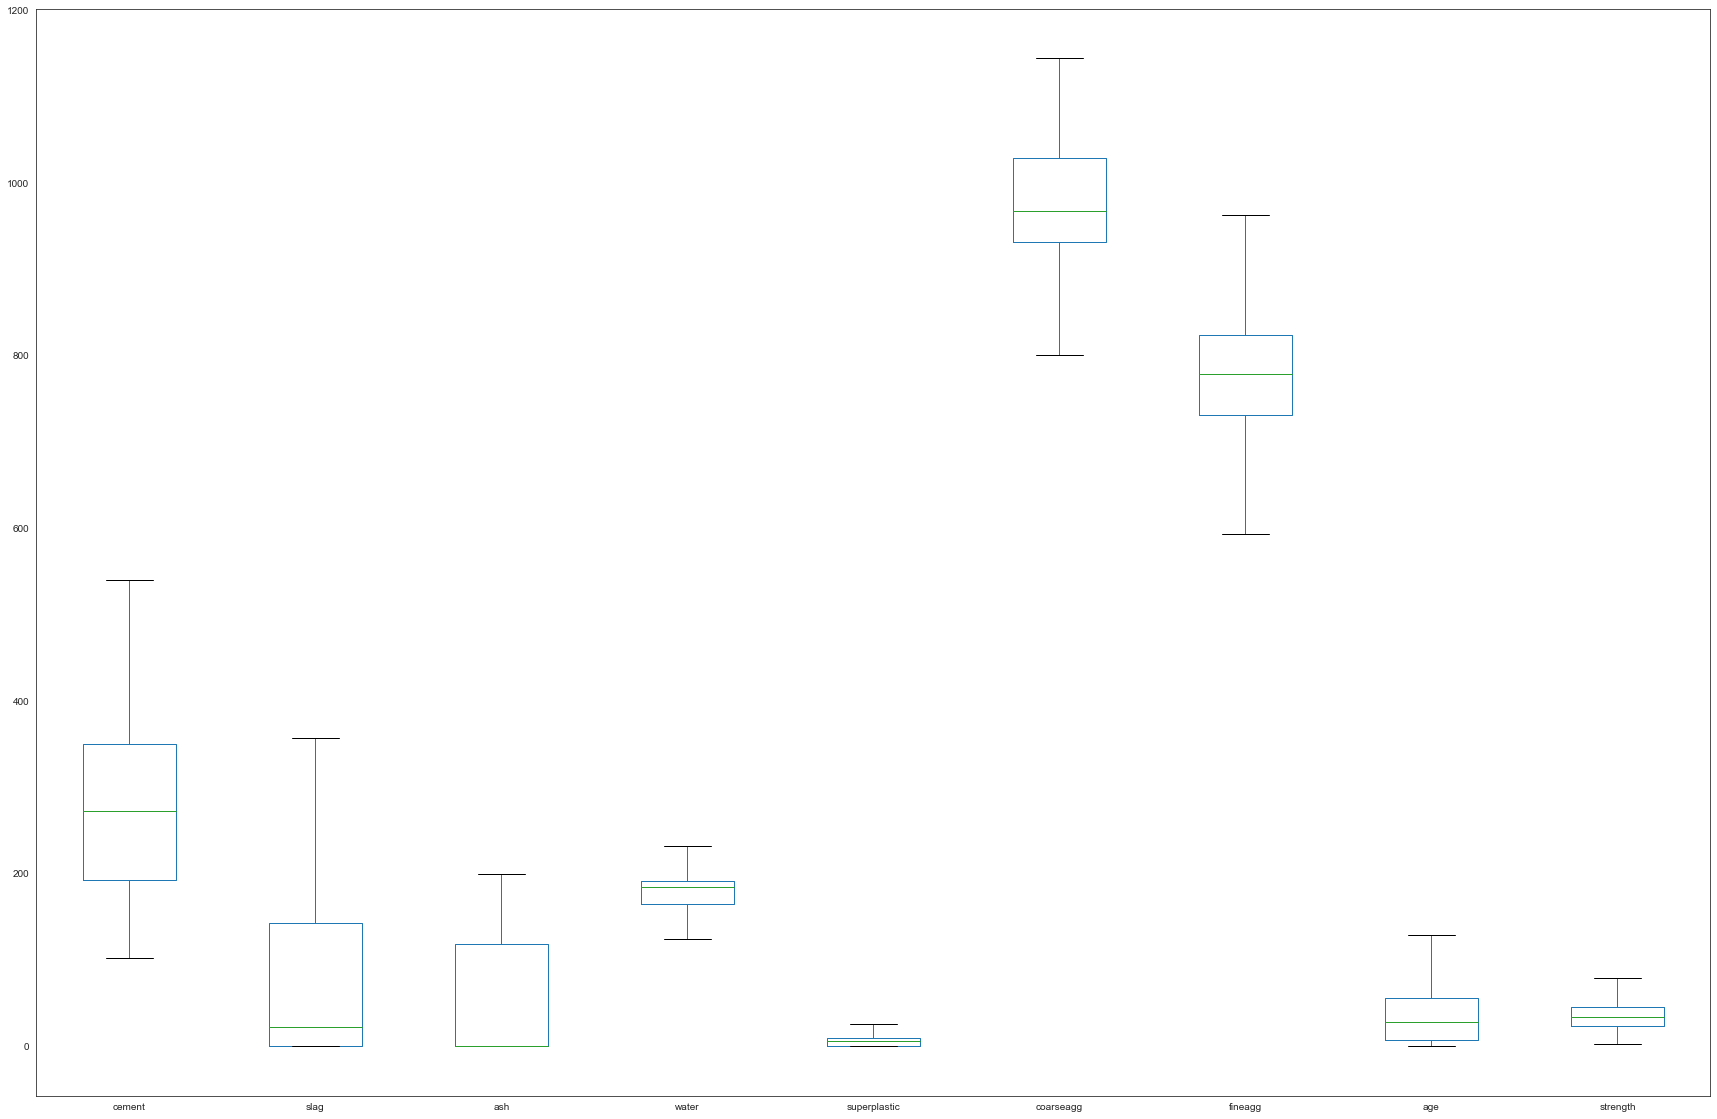

In [15]:
#funection to treat outliers in the features
outlier_features = ['slag','water', 'superplastic','fineagg','age','strength']
for col in outlier_features:
    p = np.percentile(Data[col], [25, 75])
    iqr = p[1]-p[0]
    Data.loc[:, col].clip(lower = p[0]-1.5*iqr, upper = p[1]+1.5*iqr, inplace = True)
Data.plot(kind = 'box', figsize = (30,20))


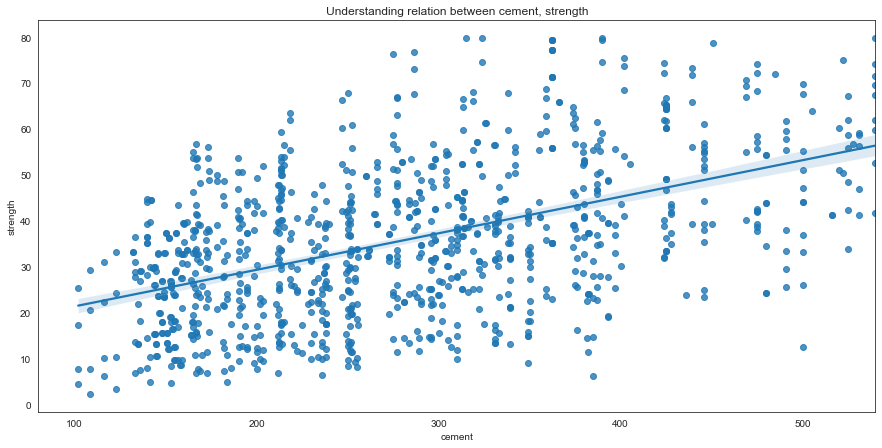

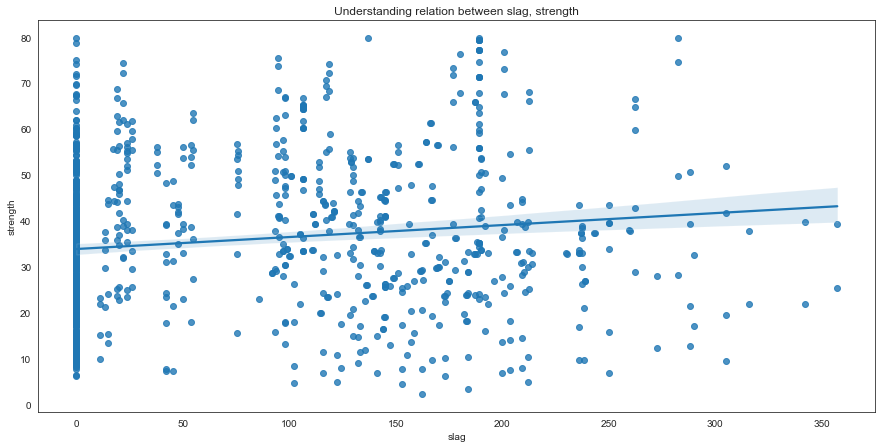

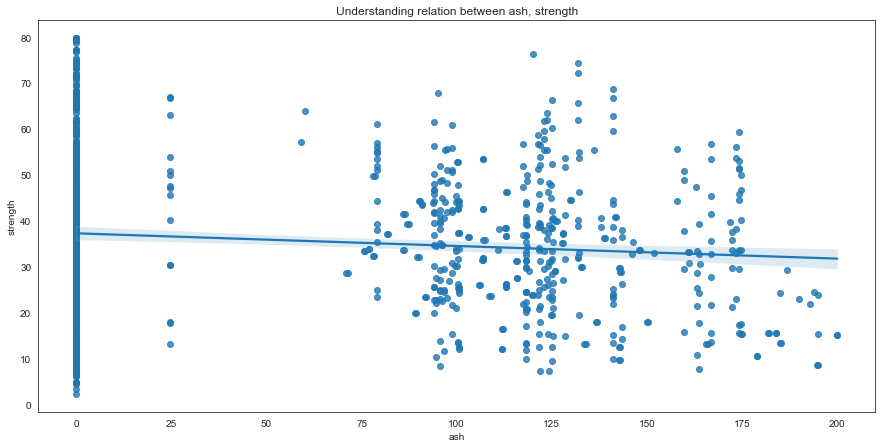

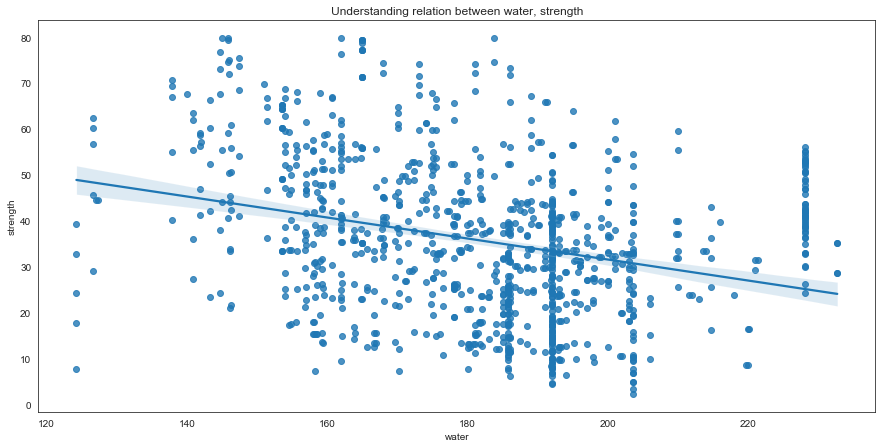

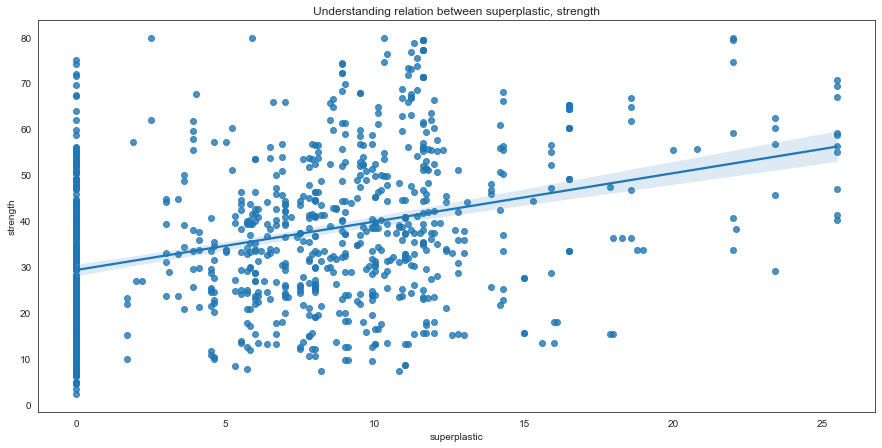

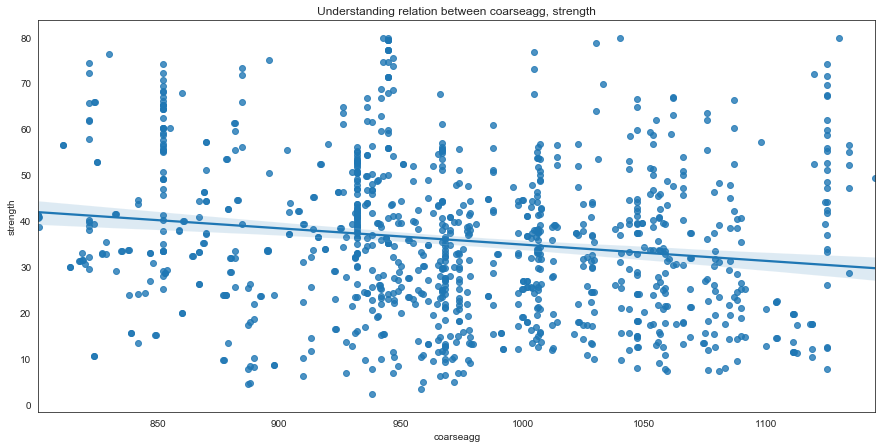

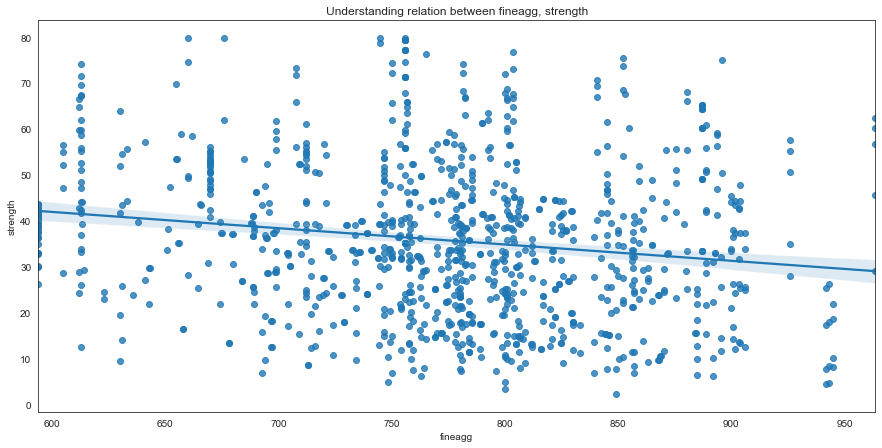

In [16]:
# Understanding relation between Strength and other indepedant variable with regplot
for col in list(Data.columns)[:-2]:
    fig, ax1 = plt.subplots(figsize = (15, 7.2), ncols = 1, sharex = False)
    sns.regplot(x = Data[col], y = Data['strength'], ax = ax1).set_title(f'Understanding relation between {col}, strength')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EB960C8>,
      dtype=object)

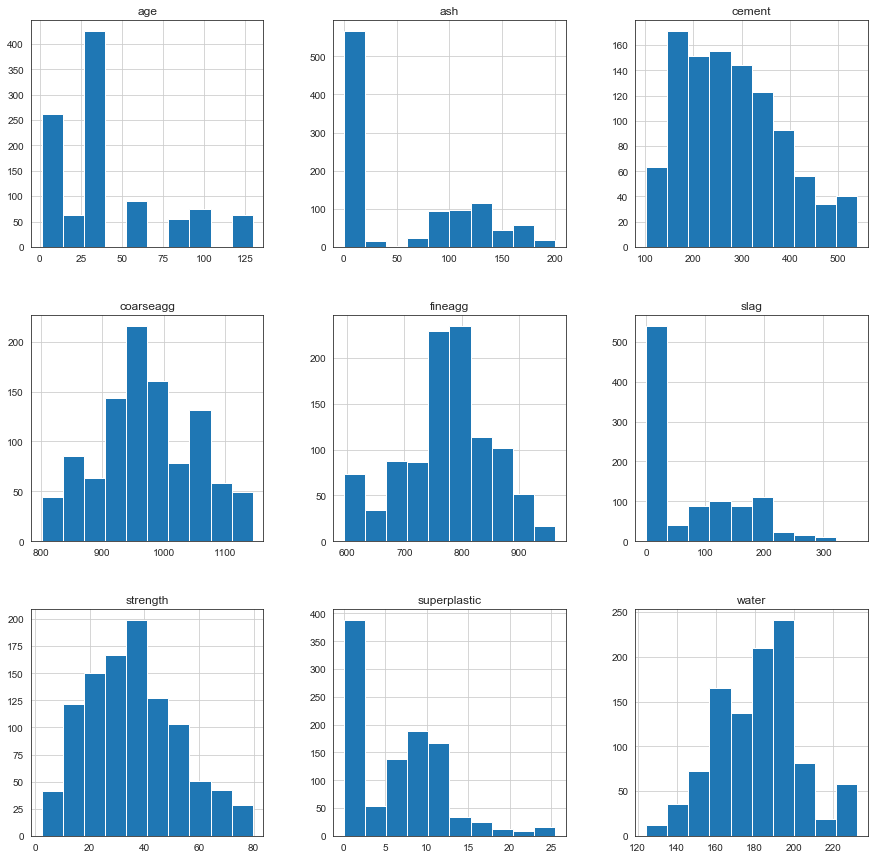

In [17]:
#Showing Data distribution using Histogram 
Data.hist(figsize=(15,15))

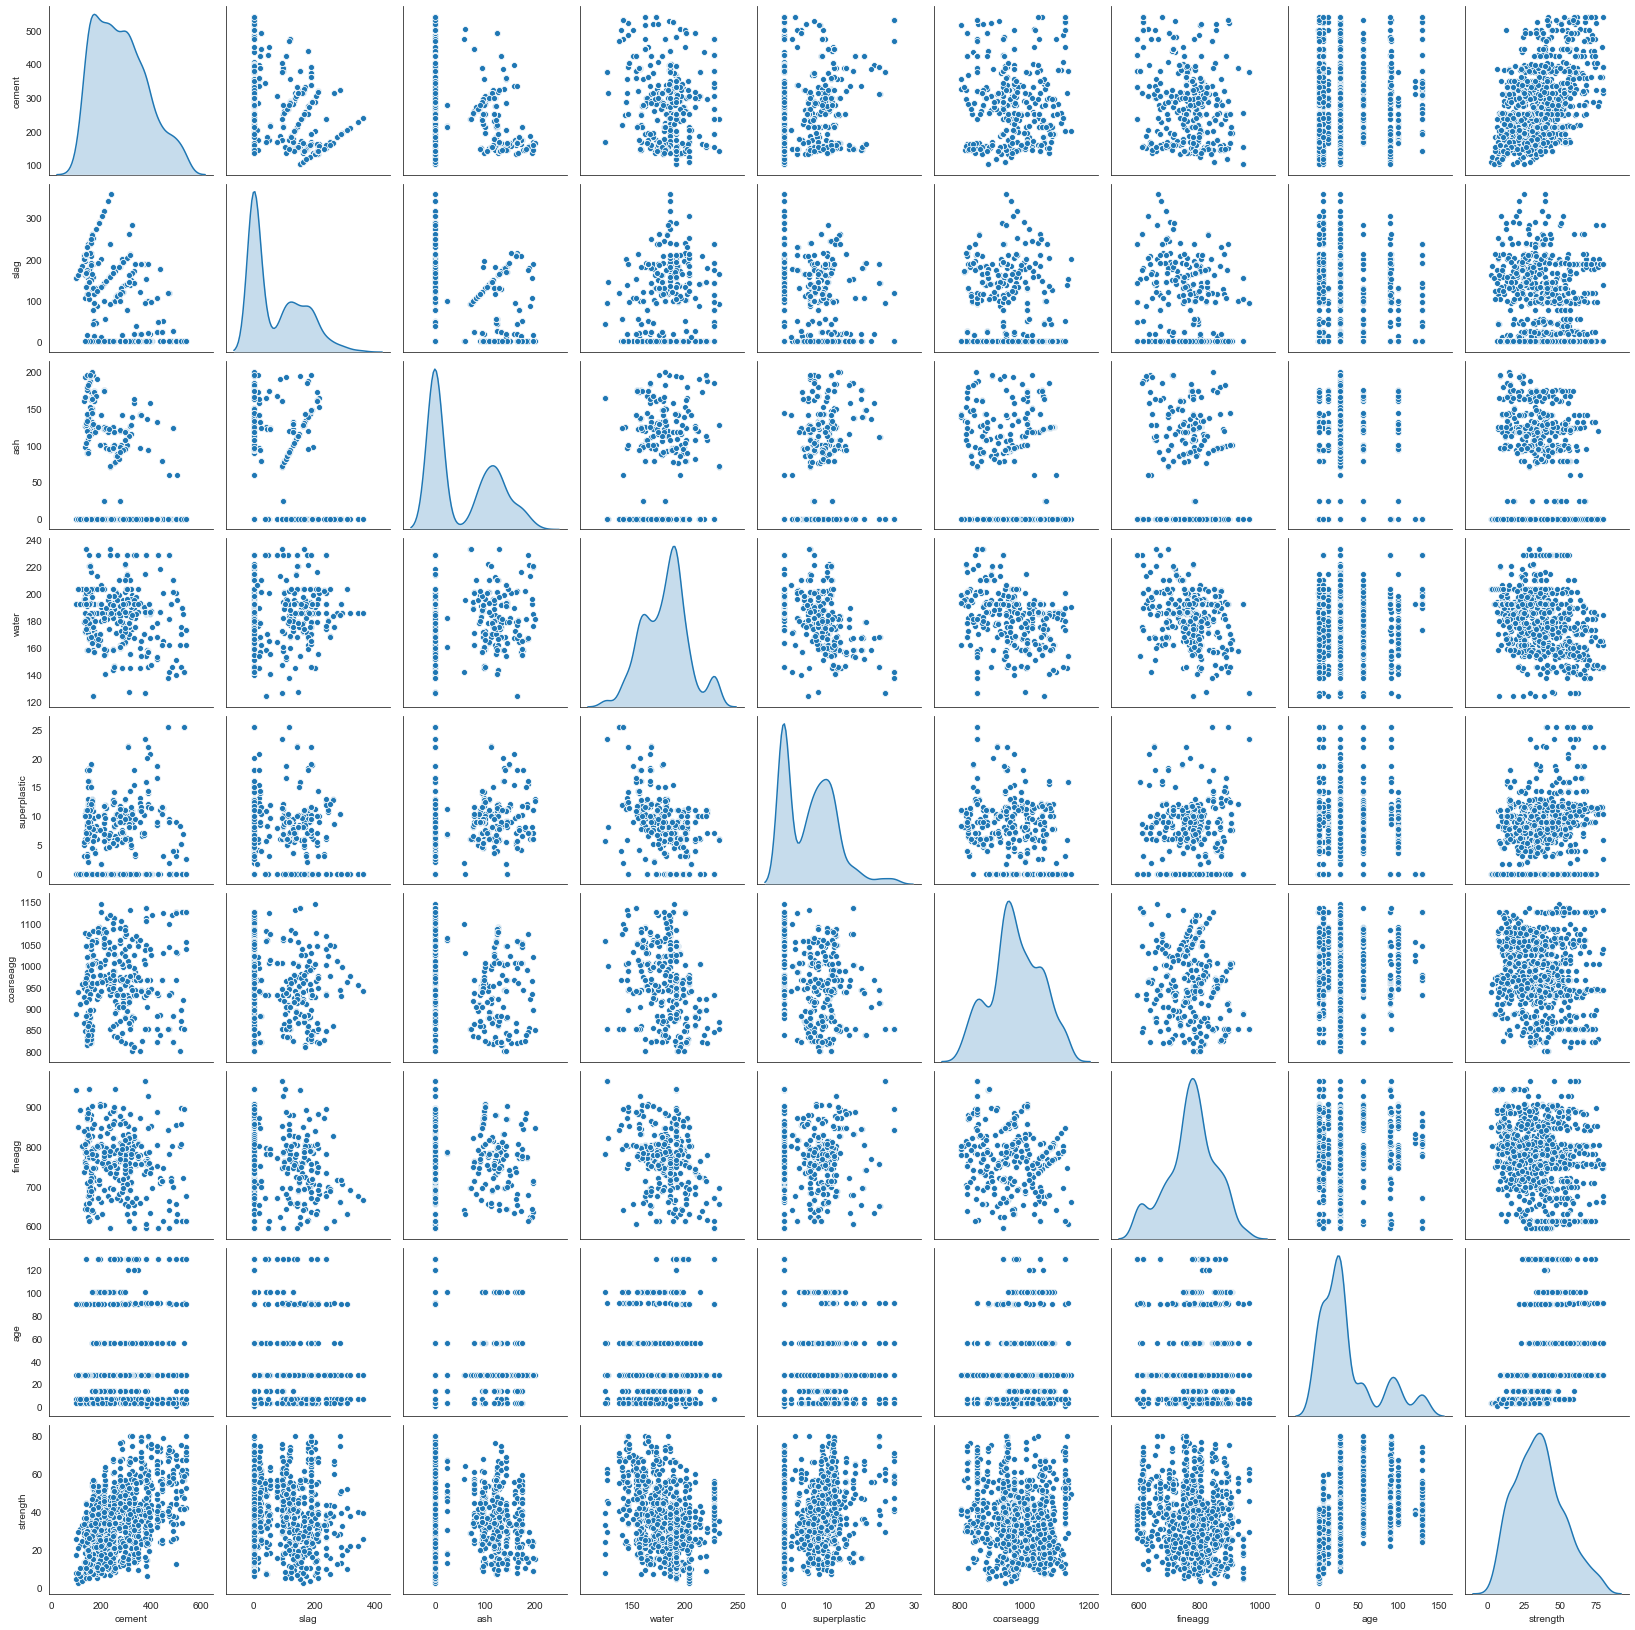

In [18]:
sns.pairplot(Data, diag_kind = 'kde')

* From above paiplot we cannot see stronger correlation between all attributes.
* There is very light correlation present in cement and strength.
* From the pairplot we can see the gaussian distribution of each varibale. Each attributs has Maximum 3 gaussian present.


### Feature Importance
Check whether there exist any important feature interaction which we can make use of to create new features

In [19]:

# Splitting the dataset into train and test set for checking feature interaction
print('Checking if there exist any important feature interaction and make use of that to create features')
print('Make use catboostregressor\'s feature interaction'); print('--'*57)

X = Data.drop('strength', axis = 1)
y = Data['strength']
features_list = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

# Initialize CatBoostRegressor
reg = CatBoostRegressor(iterations = None, eval_metric = 'RMSE', random_state = random_state)
reg.fit(X_train, y_train, early_stopping_rounds = 5, verbose = False, eval_set = [(X_test, y_test)], use_best_model = True)

Checking if there exist any important feature interaction and make use of that to create features
Make use catboostregressor's feature interaction
------------------------------------------------------------------------------------------------------------------


Feature Importance plot for catboostregressor using type = Interaction
Adding features based on cement and age; water and age can be useful
------------------------------------------------------------------------------------------------------------------


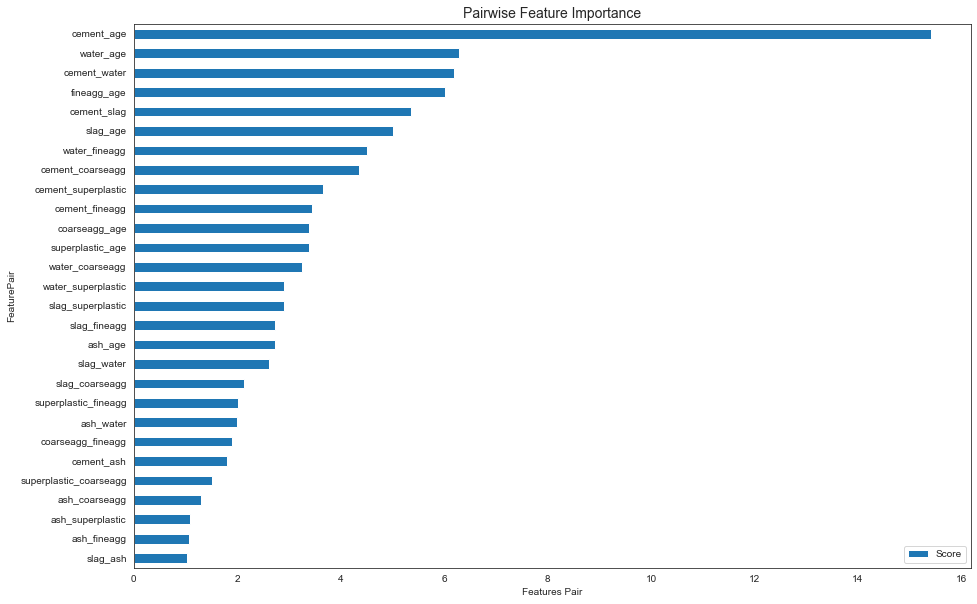

In [20]:

# Get feature importance -- Type = Interaction
print('Feature Importance plot for catboostregressor using type = Interaction'); 
print('Adding features based on cement and age; water and age can be useful'); print('--'*57)
FI = reg.get_feature_importance(Pool(X_test, label = y_test), type = 'Interaction')
FI_new = []
for k, item in enumerate(FI):  
    first = X_test.dtypes.index[FI[k][0]]
    second = X_test.dtypes.index[FI[k][1]]
    if first != second:
        FI_new.append([first + "_" + second, FI[k][2]])
feature_score = pd.DataFrame(FI_new, columns = ['FeaturePair', 'Score'])
feature_score = feature_score.sort_values(by = 'Score', ascending = True)
ax = feature_score.plot('FeaturePair', 'Score', kind = 'barh', figsize = (15, 10))
ax.set_title('Pairwise Feature Importance', fontsize = 14)
ax.set_xlabel('Features Pair')
plt.show()

#### Adding features based on feature interaction

In [21]:
# Adding features based on 'feature interaction' we got from above catboostregressor
print('Adding features based on feature interaction we got from catboostregressor\'s feature importance'); print('--'*60)

cement_age = Data.groupby('age', as_index = False)['cement'].agg(['mean', 'median'])
Data = Data.merge(cement_age, on = 'age', how = 'left')
Data.rename(columns = {'mean': 'cement_age_mean', 'median': 'cement_age_median'}, inplace = True)

water_age = Data.groupby('age')['water'].agg(['mean', 'median']);
Data = Data.merge(water_age, on = 'age', how = 'left')
Data.rename(columns = {'mean': 'water_age_mean', 'median': 'water_age_median'}, inplace = True)
Data.describe()

Adding features based on feature interaction we got from catboostregressor's feature importance
------------------------------------------------------------------------------------------------------------------------


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cement_age_mean,cement_age_median,water_age_mean,water_age_median
count,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00
mean,281.17,73.89,54.19,181.54,6.16,972.92,773.44,38.07,35.81,281.17,270.44,181.54,182.83
std,104.51,86.27,64.00,21.23,5.80,77.75,79.82,35.78,16.69,31.17,34.96,10.72,13.92
min,102.00,0.00,0.00,124.25,0.00,801.00,594.00,1.00,2.33,220.91,213.75,157.76,154.80
25%,192.38,0.00,0.00,164.90,0.00,932.00,730.95,7.00,23.71,265.44,254.50,176.21,177.25
50%,272.90,22.00,0.00,185.00,6.40,968.00,779.50,28.00,34.45,265.44,261.00,182.98,185.00
75%,350.00,142.95,118.30,192.00,10.20,1029.40,824.00,56.00,46.14,294.17,288.50,182.98,185.00
max,540.00,357.38,200.10,232.65,25.50,1145.00,963.58,129.50,79.77,442.50,442.50,210.80,228.00


In [22]:
X = Data.drop('strength', axis = 1)
y = Data['strength']
features_list = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

reg = CatBoostRegressor(iterations = None, eval_metric = 'RMSE', random_state = random_state)
reg.fit(X_train, y_train, early_stopping_rounds = 5, verbose = False, eval_set = [(X_test, y_test)], use_best_model = True)

In [23]:
# Get feature importance -- eli5
perm = PermutationImportance(reg, random_state = random_state).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.6990 ± 0.0578,cement
0.5750 ± 0.0867,age
0.2574 ± 0.0209,slag
0.2517 ± 0.0465,water
0.0583 ± 0.0159,superplastic
0.0536 ± 0.0167,fineagg
0.0371 ± 0.0116,coarseagg
0.0348 ± 0.0104,water_age_mean
0.0214 ± 0.0050,water_age_median
0.0176 ± 0.0053,ash


Feature Importance plot for catboostregressor using type = PredictionValuesChange
Age, cement and water are top 3 importance features
------------------------------------------------------------------------------------------------------------------------


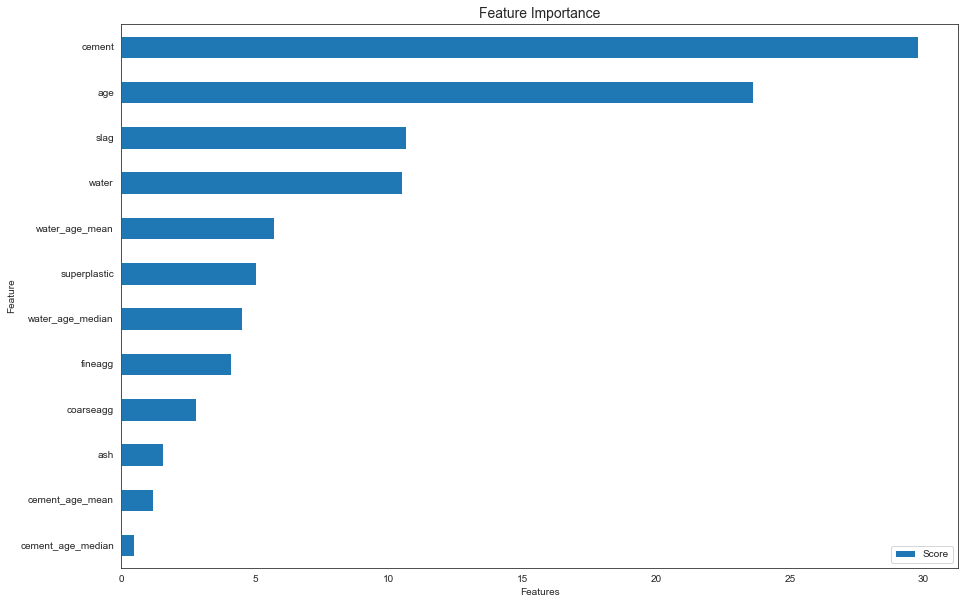

In [24]:
# Get feature importance -- model based
print('Feature Importance plot for catboostregressor using type = PredictionValuesChange'); 
print('Age, cement and water are top 3 importance features'); print('--'*60)
FI = reg.get_feature_importance(Pool(X_test, label = y_test), type = 'PredictionValuesChange')
feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, FI)), columns = ['Feature', 'Score'])
feature_score = feature_score.sort_values(by = 'Score', ascending = True)
ax = feature_score.plot('Feature', 'Score', kind = 'barh', figsize = (15, 10))
ax.set_title('Feature Importance', fontsize = 14)
ax.set_xlabel('Features')
plt.show()

In [25]:
# Absolute correlation of independent variables with the target variable
absCorrwithDep = []
allVars = Data.drop('strength', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(Data['strength'].corr(Data[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

,Variable,Correlation
0,cement,0.50
7,age,0.47
4,superplastic,0.37
3,water,0.29
6,fineagg,0.17
5,coarseagg,0.17
1,slag,0.13
2,ash,0.11
8,cement_age_mean,0.08
11,water_age_median,0.08


* In the feature engineering steps we identified that there clusters between cement and rest of the independent features. Used that to add features based on cement and cluster labels. Features were added for min, max, mean and median values for cement-labels group.
* Further, we also made use of CatBoostRegressor's feature interaction to add features based on cement and age; water and age interaction.
* While doing this steps, we added 6 new features. It was important to check feature importance and correlation matrix at this stage.
* age, cement, water, slag are some of the importance features based on eli5 and model based feature importance. Dropping all newly added features since they resulted in multicollinearity.

### Model Complexity
Decide on complexity of the model, should it be simple linear mode in terms of parameters or would a quadratic or higher degree help

In [26]:
print('Split into training (70%), validation(10%) and test(20%) sets for both with EDA and FE & without EDA and FE.')
print('--'*60)

# Training, validation and test sets with outliers
X = Data1.drop('strength', axis = 1); y = Data1['strength']; features_list = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.12, random_state = random_state)
print(f'Shape of train, valid and test datasets without EDA, FE: {(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)}')
print(f'Proportion in the splits for train, valid, test datasets without EDA, FE: {round(len(X_train)/len(X), 2), round(len(X_val)/len(X), 2), round(len(X_test)/len(X), 2)}')

# Training, validation and test sets without outliers
X = Data.drop('strength', axis = 1); y = Data['strength']; features_list = list(X.columns)
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size = 0.2, random_state = random_state)
X_train_fe, X_val_fe, y_train_fe, y_val_fe = train_test_split(X_train_fe, y_train_fe, test_size = 0.12, random_state = random_state)
print(f'\nShape of train, valid and test datasets with EDA, FE: {(X_train_fe.shape, y_train_fe.shape, X_val_fe.shape, y_val_fe.shape, X_test_fe.shape, y_test_fe.shape)}')
print(f'Proportion in the splits for train, valid, test datasets with EDA, FE: {round(len(X_train_fe)/len(X), 2), round(len(X_val_fe)/len(X), 2), round(len(X_test_fe)/len(X), 2)}')

training_test_sets = {'withoutedafe': (X_train, y_train, X_val, y_val), 'withedafe': (X_train_fe, y_train_fe, X_val_fe, y_val_fe)}

Split into training (70%), validation(10%) and test(20%) sets for both with EDA and FE & without EDA and FE.
------------------------------------------------------------------------------------------------------------------------
Shape of train, valid and test datasets without EDA, FE: ((725, 8), (725,), (99, 8), (99,), (206, 8), (206,))
Proportion in the splits for train, valid, test datasets without EDA, FE: (0.7, 0.1, 0.2)

Shape of train, valid and test datasets with EDA, FE: ((725, 12), (725,), (99, 12), (99,), (206, 12), (206,))
Proportion in the splits for train, valid, test datasets with EDA, FE: (0.7, 0.1, 0.2)


In [27]:
print('Let\'s check cross validated scores on linear models and tree-based models on training and validation sets with and without EDA & FE')
print('--'*57)
models = []
models.append(('Linear', LinearRegression()))
models.append(('Lasso', Lasso(random_state = random_state)))
models.append(('Ridge', Ridge(random_state = random_state)))
models.append(('SVR', SVR()))
models.append(('DecisionTree', DecisionTreeRegressor(random_state = random_state)))
models.append(('GradientBoost', GradientBoostingRegressor(random_state = random_state)))
models.append(('AdaBoost', AdaBoostRegressor(random_state = random_state)))
models.append(('ExtraTrees', ExtraTreesRegressor(random_state = random_state)))
models.append(('RandomForest', RandomForestRegressor(random_state = random_state)))
models.append(('Bagging', BaggingRegressor(DecisionTreeRegressor(random_state = random_state), random_state = random_state)))
models.append(('CatBoost', CatBoostRegressor(random_state = random_state, silent = True)))

scoring = 'r2'; results = {}; score = {}

for encoding_label, (_X_train, _y_train, _X_val, _y_val) in training_test_sets.items():
  scores = []; result_cv = []; names = []
  for name, model in models:
    kf = KFold(n_splits = 10, random_state = random_state)
    cv_results = cross_val_score(model, _X_train, _y_train, cv = kf, scoring = scoring)
    result_cv.append(cv_results); names.append(name)
    scores.append([name, cv_results.mean().round(4), cv_results.std().round(4)])
  score[encoding_label] = scores
  results[encoding_label] = [names, result_cv]

pd.options.display.float_format = "{:.4f}".format

scores_df = pd.concat([pd.DataFrame(score['withoutedafe'], columns = ['Model', 'R2 (Mean) Without', 'R2 (Std) Without']).set_index('Model'), 
           pd.DataFrame(score['withedafe'], columns = ['Model', 'R2 (Mean) With', 'R2 (Std) With']).set_index('Model')], axis = 1)
scores_df['Improvement?'] = scores_df['R2 (Mean) With'] - scores_df['R2 (Mean) Without']
display(scores_df)

Let's check cross validated scores on linear models and tree-based models on training and validation sets with and without EDA & FE
------------------------------------------------------------------------------------------------------------------


,R2 (Mean) Without,R2 (Std) Without,R2 (Mean) With,R2 (Std) With,Improvement?
Model,,,,,
Linear,0.6111,0.0585,0.7656,0.0610,0.1545
Lasso,0.6104,0.0605,0.7668,0.0592,0.1564
Ridge,0.6111,0.0585,0.7656,0.0610,0.1545
SVR,0.2173,0.0372,0.2224,0.0333,0.0051
DecisionTree,0.7862,0.0715,0.7943,0.0652,0.0081
GradientBoost,0.8951,0.0365,0.8975,0.0294,0.0024
AdaBoost,0.7876,0.0360,0.7948,0.0392,0.0072
ExtraTrees,0.9068,0.0381,0.8987,0.0400,-0.0081
RandomForest,0.8945,0.0316,0.8938,0.0321,-0.0007


A significant improvement in r2 scores after EDA & FE for linear algorithms whereas remains almost same for tree-based algorithms.
------------------------------------------------------------------------------------------------------------------------


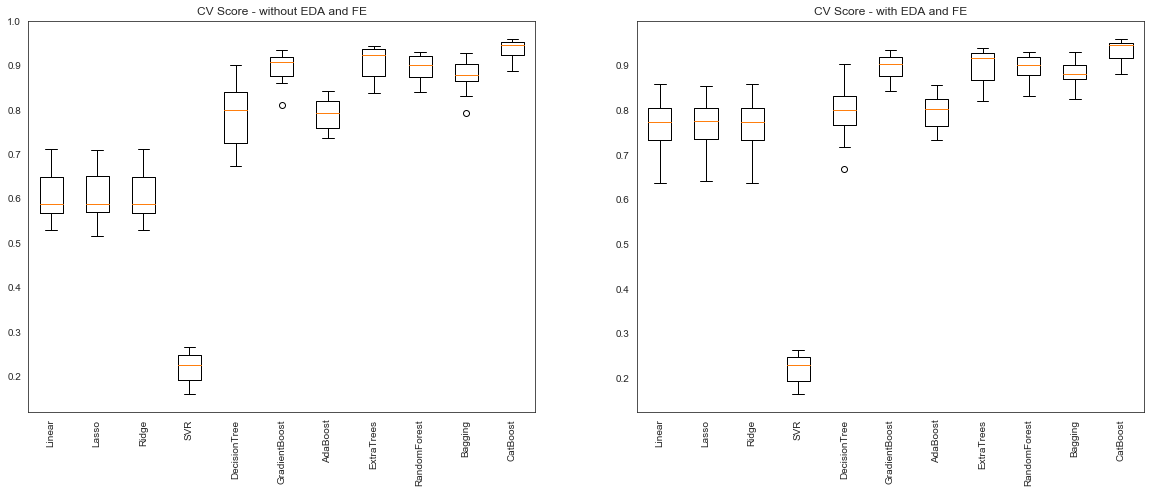

In [28]:
print('A significant improvement in r2 scores after EDA & FE for linear algorithms whereas remains almost same for tree-based algorithms.'); print('--'*60)

fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7.2))
ax1.boxplot(results['withoutedafe'][1]); ax1.set_xticklabels(results['withoutedafe'][0], rotation = 90); ax1.set_title('CV Score - without EDA and FE')
ax2.boxplot(results['withedafe'][1]); ax2.set_xticklabels(results['withedafe'][0], rotation = 90); ax2.set_title('CV Score - with EDA and FE')
plt.show()

#### Model Complexity
* We see an improvement in the scores against the uncleaned data we had. Improvements are clearly seen for linear algos whereas for tree-based it either marginally increases/decreases.
* Tree-based algorithms are a clear choice when it comes to linear vs tree-based comparison.
* CatboostRegressor gives us the highest r2 score.

In [29]:

def train_val_predict(basemodel, train_X, train_y, test_X, test_y, name, model):

  folds = list(KFold(n_splits = 5, random_state = random_state, shuffle = True).split(train_X, train_y))
  
  r2_scores_train = []; r2_scores_val = []; r2_scores_test = []

  for j, (train_index, val_index) in enumerate(folds):
    X_train = train_X.iloc[train_index]
    y_train = train_y.iloc[train_index]
    X_val = train_X.iloc[val_index]
    y_val = train_y.iloc[val_index]

    if model == 'CatBoost':
      basemodel.fit(X_train, y_train, early_stopping_rounds = 5, verbose = 300, eval_set = [(X_val, y_val)], use_best_model = True)
    else:
      basemodel.fit(X_train, y_train)

    pred = basemodel.predict(X_train)
    r2 = r2_score(y_train, pred); r2_scores_train.append(r2)
    
    pred = basemodel.predict(X_val)
    r2 = r2_score(y_val, pred); r2_scores_val.append(r2)

    pred = basemodel.predict(X_test_fe)
    r2 = r2_score(y_test_fe, pred); r2_scores_test.append(r2)

  df = pd.DataFrame([np.mean(r2_scores_train), np.mean(r2_scores_val), np.mean(r2_scores_test)],
                    index = ['r2 Scores Train', 'r2 Scores Val', 'r2 Scores Test'], 
                    columns = [name]).T
  return df

In [30]:
print('Separating the dependents and independents + Scaling the data'); print('--'*57)
features_list = list(Data.columns)
Data = Data.apply(zscore); concrete_im = pd.DataFrame(Data , columns = features_list)
display(Data.describe())

X = Data.drop('strength', axis = 1); y = Data['strength']; 
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size = 0.2, random_state = random_state)

X_train_fe.shape, X_test_fe.shape, y_train_fe.shape, y_test_fe.shape

Separating the dependents and independents + Scaling the data
------------------------------------------------------------------------------------------------------------------


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cement_age_mean,cement_age_median,water_age_mean,water_age_median
count,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000,1030.0000
mean,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000
std,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005
min,-1.7153,-0.8570,-0.8471,-2.7006,-1.0620,-2.2121,-2.2493,-1.0365,-2.0070,-1.9339,-1.6222,-2.2199,-2.0152
25%,-0.8501,-0.8570,-0.8471,-0.7845,-1.0620,-0.5265,-0.5326,-0.8687,-0.7254,-0.5046,-0.4561,-0.4981,-0.4014
50%,-0.0792,-0.6018,-0.8471,0.1629,0.0415,-0.0633,0.0760,-0.2816,-0.0820,-0.5046,-0.2701,0.1340,0.1557
75%,0.6590,0.8009,1.0023,0.4929,0.6968,0.7268,0.6338,0.5013,0.6187,0.4174,0.5169,0.1340,0.1557
max,2.4779,3.2877,2.2811,2.4090,3.3349,2.2142,2.3833,2.5564,2.6350,5.1777,4.9238,2.7308,3.2467


((824, 12), (206, 12), (824,), (206,))

### 1. Linear Regression, Lasso, Ridge

In [31]:
lr_reg = LinearRegression()
df_lr = train_val_predict(lr_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold LinearRegression', model = 'LR')

In [32]:
%%time
print('Using the 5-Fold Lasso Regression to train, validate and predict'); print('--'*57)
lasso_reg = Lasso(alpha = 0.01)
df_lasso = train_val_predict(lasso_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold LassoRegression', model = 'Lasso')
df = df_lr.append(df_lasso)

Using the 5-Fold Lasso Regression to train, validate and predict
------------------------------------------------------------------------------------------------------------------
Wall time: 211 ms


In [33]:

%%time
print('Using the 5-Fold Ridge Regression to train, validate and predict'); print('--'*57)
ridge_reg = Ridge(alpha = 0.01)
df_ridge = train_val_predict(ridge_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RidgeRegression', model = 'Ridge')
df = df.append(df_ridge)
display(df)

Using the 5-Fold Ridge Regression to train, validate and predict
------------------------------------------------------------------------------------------------------------------


,r2 Scores Train,r2 Scores Val,r2 Scores Test
5-Fold LinearRegression,0.7857,0.7748,0.6666
5-Fold LassoRegression,0.7803,0.7698,0.6715
5-Fold RidgeRegression,0.7857,0.7748,0.6666


Wall time: 274 ms


### 2. Decision Tree and Random Forest

In [34]:
%%time
print('Finding out the hyperparameters for Decision Tree and Random Forest with GridSearchCV'); print('--'*57)
best_params_grid = {}

# Decision Tree and Random Forest Regressor Hyperparameters Grid
param_grid = {'DecisionTree': {'criterion': ['mse', 'mae'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
              'RandomForest': {'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                                'max_features': ['auto', 'sqrt'], 'n_estimators': [200, 400, 600, 800]}}

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state = random_state)
dt_reg_grid = GridSearchCV(dt_reg, param_grid['DecisionTree'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
dt_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['DecisionTree'] = dt_reg_grid.best_params_

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state = random_state)
rf_reg_grid = GridSearchCV(rf_reg, param_grid['RandomForest'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
rf_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['RandomForest'] = rf_reg_grid.best_params_

print(f'Best parameters for Decision Tree and Random Forest using GridSearchCV: {best_params_grid}')

Finding out the hyperparameters for Decision Tree and Random Forest with GridSearchCV
------------------------------------------------------------------------------------------------------------------
Best parameters for Decision Tree and Random Forest using GridSearchCV: {'DecisionTree': {'criterion': 'mse', 'max_depth': 10}, 'RandomForest': {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 600}}
Wall time: 17min 46s


In [35]:
%%time
print('Finding out the hyperparameters for Decision Tree and Random Forest with RandomizedSearchCV'); print('--'*57)
best_params_random = {}

# Decision Tree and Random Forest Regressor Hyperparameters Grid
param_grid = {'DecisionTree': {'criterion': ['mse', 'mae'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
              'RandomForest': {'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                                'max_features': ['auto', 'sqrt'], 'n_estimators': [200, 400, 600, 800]}}

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state = random_state)
dt_reg_grid = RandomizedSearchCV(dt_reg, param_grid['DecisionTree'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
dt_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['DecisionTree'] = dt_reg_grid.best_params_

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state = random_state)
rf_reg_grid = RandomizedSearchCV(rf_reg, param_grid['RandomForest'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
rf_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['RandomForest'] = rf_reg_grid.best_params_

print(f'Best parameters for Decision Tree and Random Forest using RandomizedSearchCV: {best_params_random}')

Finding out the hyperparameters for Decision Tree and Random Forest with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------
Best parameters for Decision Tree and Random Forest using RandomizedSearchCV: {'DecisionTree': {'max_depth': 10, 'criterion': 'mse'}, 'RandomForest': {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}}
Wall time: 1min 8s


In [36]:

%%time
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict'); print('--'*57)
dt_reg = DecisionTreeRegressor(random_state = random_state)
df_reg = train_val_predict(dt_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree', model = 'DT')
df = df.append(df_reg)

Using the 5-Fold Decision Tree Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------
Wall time: 140 ms


In [37]:
%%time
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict using GridSearchCV'); print('--'*57)
dt_reg_grid = DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree'])
df_reg_grid = train_val_predict(dt_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree GridSearchCV', model = 'DT')
df = df.append(df_reg_grid)

Using the 5-Fold Decision Tree Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------
Wall time: 178 ms


In [38]:
%%time
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*57)
dt_reg_rand = DecisionTreeRegressor(random_state = random_state, **best_params_random['DecisionTree'])
df_reg_rand = train_val_predict(dt_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree RandomizedSearchCV', model = 'DT')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Decision Tree Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------


,r2 Scores Train,r2 Scores Val,r2 Scores Test
5-Fold LinearRegression,0.7857,0.7748,0.6666
5-Fold LassoRegression,0.7803,0.7698,0.6715
5-Fold RidgeRegression,0.7857,0.7748,0.6666
5-Fold DecisionTree,0.9966,0.8081,0.7314
5-Fold DecisionTree GridSearchCV,0.9824,0.8155,0.7344
5-Fold DecisionTree RandomizedSearchCV,0.9824,0.8155,0.7344


Wall time: 148 ms


In [39]:

%%time
print('Using the 5-Fold Random Forest Regressor to train, validate and predict'); print('--'*57)
rf_reg = RandomForestRegressor(random_state = random_state)
df_reg = train_val_predict(rf_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest', model = 'RF')
df = df.append(df_reg)

Using the 5-Fold Random Forest Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------
Wall time: 3.43 s


In [40]:
%%time
print('Using the 5-Fold Random Forest Regressor to train, validate and predict using GridSearchCV'); print('--'*57)
rf_reg_grid = RandomForestRegressor(random_state = random_state, **best_params_grid['RandomForest'])
df_reg_grid = train_val_predict(rf_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest GridSearchCV', model = 'RF')
df = df.append(df_reg_grid)

Using the 5-Fold Random Forest Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------
Wall time: 19.6 s


In [41]:
%%time
print('Using the 5-Fold Random Forest Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*57)
rf_reg_rand = RandomForestRegressor(random_state = random_state, **best_params_random['RandomForest'])
df_reg_rand = train_val_predict(rf_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest RandomizedSearchCV', model = 'RF')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Random Forest Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------


,r2 Scores Train,r2 Scores Val,r2 Scores Test
5-Fold LinearRegression,0.7857,0.7748,0.6666
5-Fold LassoRegression,0.7803,0.7698,0.6715
5-Fold RidgeRegression,0.7857,0.7748,0.6666
5-Fold DecisionTree,0.9966,0.8081,0.7314
5-Fold DecisionTree GridSearchCV,0.9824,0.8155,0.7344
5-Fold DecisionTree RandomizedSearchCV,0.9824,0.8155,0.7344
5-Fold RandomForest,0.9839,0.9075,0.8727
5-Fold RandomForest GridSearchCV,0.9846,0.9075,0.8739
5-Fold RandomForest RandomizedSearchCV,0.9821,0.8944,0.8706


Wall time: 4.6 s


### 3. AdaBoost, GradientBoost and ExtraTrees

In [42]:
%%time
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict'); print('--'*57)
ada_reg = AdaBoostRegressor(random_state = random_state)
df_reg = train_val_predict(ada_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost', model = 'Ada')
df = df.append(df_reg)

Using the 5-Fold Ada Boost Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------
Wall time: 1.22 s


In [43]:
%%time
# AdaBoost Regressor Hyperparameters Grid
print('Finding out the hyperparameters for AdaBoostRegressor with GridSearchCV'); print('--'*57)

param_grid = {'AdaBoost': {'base_estimator': [DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree']), None],
                           'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.1, 1.0]}}

# AdaBoost Regressor
ada_reg = AdaBoostRegressor(random_state = random_state)
ada_reg_grid = GridSearchCV(ada_reg, param_grid['AdaBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
ada_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['AdaBoost'] = ada_reg_grid.best_params_

print('Best parameters for AdaBoost Regressor using GridSearchCV: {}'.format(best_params_grid['AdaBoost']))

Finding out the hyperparameters for AdaBoostRegressor with GridSearchCV
------------------------------------------------------------------------------------------------------------------
Best parameters for AdaBoost Regressor using GridSearchCV: {'base_estimator': DecisionTreeRegressor(max_depth=10, random_state=2019), 'learning_rate': 0.1, 'n_estimators': 150}
Wall time: 37.1 s


In [44]:
%%time
# AdaBoost Regressor Hyperparameters Grid
print('Finding out the hyperparameters for AdaBoostRegressor with RandomizedSearchCV'); print('--'*57)

param_grid = {'AdaBoost': {'base_estimator': [DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree']), None],
                           'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.1, 1.0]}}

# AdaBoost Regressor
ada_reg = AdaBoostRegressor(random_state = random_state)
ada_reg_grid = RandomizedSearchCV(ada_reg, param_grid['AdaBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
ada_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['AdaBoost'] = ada_reg_grid.best_params_

print('Best parameters for AdaBoost Regressor using RandomizedSearchCV: {}'.format(best_params_random['AdaBoost']))

Finding out the hyperparameters for AdaBoostRegressor with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------
Best parameters for AdaBoost Regressor using RandomizedSearchCV: {'n_estimators': 150, 'learning_rate': 0.1, 'base_estimator': DecisionTreeRegressor(max_depth=10, random_state=2019)}
Wall time: 20.3 s


In [45]:

%%time
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict using GridSearchCV'); print('--'*57)
ada_reg_grid = AdaBoostRegressor(random_state = random_state, **best_params_grid['AdaBoost'])
df_reg_grid = train_val_predict(ada_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost using GridSearchCV', model = 'Ada')
df = df.append(df_reg_grid)

Using the 5-Fold Ada Boost Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------
Wall time: 5.08 s


In [46]:
%%time
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*57)
ada_reg_rand = AdaBoostRegressor(random_state = random_state, **best_params_random['AdaBoost'])
df_reg_rand = train_val_predict(ada_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost using RandomizedSearchCV', model = 'Ada')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Ada Boost Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------


,r2 Scores Train,r2 Scores Val,r2 Scores Test
5-Fold LinearRegression,0.7857,0.7748,0.6666
5-Fold LassoRegression,0.7803,0.7698,0.6715
5-Fold RidgeRegression,0.7857,0.7748,0.6666
5-Fold DecisionTree,0.9966,0.8081,0.7314
5-Fold DecisionTree GridSearchCV,0.9824,0.8155,0.7344
5-Fold DecisionTree RandomizedSearchCV,0.9824,0.8155,0.7344
5-Fold RandomForest,0.9839,0.9075,0.8727
5-Fold RandomForest GridSearchCV,0.9846,0.9075,0.8739
5-Fold RandomForest RandomizedSearchCV,0.9821,0.8944,0.8706
5-Fold AdaBoost,0.8307,0.7939,0.7119


Wall time: 4.94 s


### Gradient Boost

In [47]:
%%time
# GradientBoostRegressor Hyperparameters Grid
print('Finding out the hyperparameters for GradientBoostRegressor with GridSearchCV'); print('--'*57)

param_grid = {'GradientBoost': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [600, 800, 1000]}}

# GradientBoostRegressor
gb_reg = GradientBoostingRegressor(random_state = random_state)
gb_reg_grid = GridSearchCV(gb_reg, param_grid['GradientBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
gb_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['GradientBoost'] = gb_reg_grid.best_params_

print('Best parameters for Gradient Boost Regressor using GridSearchCV: {}'.format(best_params_grid['GradientBoost']))

Finding out the hyperparameters for GradientBoostRegressor with GridSearchCV
------------------------------------------------------------------------------------------------------------------
Best parameters for Gradient Boost Regressor using GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 600}
Wall time: 4min 17s


In [48]:
%%time
# GradientBoostRegressor Hyperparameters Grid
print('Finding out the hyperparameters for GradientBoostRegressor with RandomizedSearchCV'); print('--'*57)

param_grid = {'GradientBoost': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [600, 800, 1000]}}

# GradientBoostRegressor
gb_reg = GradientBoostingRegressor(random_state = random_state)
gb_reg_rand = RandomizedSearchCV(gb_reg, param_grid['GradientBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
gb_reg_rand.fit(X_train_fe, y_train_fe)
best_params_random['GradientBoost'] = gb_reg_rand.best_params_

print('Best parameters for Gradient Boost Regressor using RandomizedSearchCV: {}'.format(best_params_random['GradientBoost']))

Finding out the hyperparameters for GradientBoostRegressor with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------
Best parameters for Gradient Boost Regressor using RandomizedSearchCV: {'n_estimators': 600, 'max_features': 'sqrt', 'max_depth': 5}
Wall time: 40 s


In [49]:
%%time
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict'); print('--'*57)
gb_reg = GradientBoostingRegressor(random_state = random_state)
df_reg = train_val_predict(gb_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost', model = 'GB')
df = df.append(df_reg)

Using the 5-Fold Gradient Boost Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------
Wall time: 1.09 s


In [50]:
%%time
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict using GridSearchCV'); print('--'*57)
gb_reg_grid = GradientBoostingRegressor(random_state = random_state, **best_params_grid['GradientBoost'])
df_reg_grid = train_val_predict(gb_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost using GridSearchCV', model = 'GB')
df = df.append(df_reg_grid)

Using the 5-Fold Gradient Boost Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------
Wall time: 3.79 s


In [51]:

%%time
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*57)
gb_reg_rand = GradientBoostingRegressor(random_state = random_state, **best_params_random['GradientBoost'])
df_reg_rand = train_val_predict(gb_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost using RandomizedSearchCV', model = 'GB')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Gradient Boost Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------


,r2 Scores Train,r2 Scores Val,r2 Scores Test
5-Fold LinearRegression,0.7857,0.7748,0.6666
5-Fold LassoRegression,0.7803,0.7698,0.6715
5-Fold RidgeRegression,0.7857,0.7748,0.6666
5-Fold DecisionTree,0.9966,0.8081,0.7314
5-Fold DecisionTree GridSearchCV,0.9824,0.8155,0.7344
5-Fold DecisionTree RandomizedSearchCV,0.9824,0.8155,0.7344
5-Fold RandomForest,0.9839,0.9075,0.8727
5-Fold RandomForest GridSearchCV,0.9846,0.9075,0.8739
5-Fold RandomForest RandomizedSearchCV,0.9821,0.8944,0.8706
5-Fold AdaBoost,0.8307,0.7939,0.7119


Wall time: 3.83 s


### ExtraTreesRegressor

In [52]:
%%time
# ExtraTreesRegressor Hyperparameters Grid
print('Finding out the hyperparameters for ExtraTreesRegressor with GridSearchCV'); print('--'*57)

param_grid = {'ExtraTrees': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [100, 600, 800, 1000]}}

# ExtraTreesRegressor
et_reg = ExtraTreesRegressor(random_state = random_state)
et_reg_grid = GridSearchCV(et_reg, param_grid['ExtraTrees'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
et_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['ExtraTrees'] = et_reg_grid.best_params_

print('Best parameters for Extra Trees Regressor using GridSearchCV: {}'.format(best_params_grid['ExtraTrees']))

Finding out the hyperparameters for ExtraTreesRegressor with GridSearchCV
------------------------------------------------------------------------------------------------------------------
Best parameters for Extra Trees Regressor using GridSearchCV: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 600}
Wall time: 4min 38s


In [53]:

%%time
# ExtraTreesRegressor Hyperparameters Grid
print('Finding out the hyperparameters for ExtraTreesRegressor with RandomizedSearchCV'); print('--'*57)

param_grid = {'ExtraTrees': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [100, 600, 800, 1000]}}

# ExtraTreesRegressor
et_reg = ExtraTreesRegressor(random_state = random_state)
et_reg_rand = RandomizedSearchCV(et_reg, param_grid['ExtraTrees'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
et_reg_rand.fit(X_train_fe, y_train_fe)
best_params_random['ExtraTrees'] = et_reg_rand.best_params_

print('Best parameters for Extra Trees Regressor using RandomizedSearchCV: {}'.format(best_params_random['ExtraTrees']))

Finding out the hyperparameters for ExtraTreesRegressor with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------
Best parameters for Extra Trees Regressor using RandomizedSearchCV: {'n_estimators': 600, 'max_features': 'auto', 'max_depth': None}
Wall time: 49.6 s


In [54]:
%%time
print('Using the 5-Fold Extra Trees Regressor to train, validate and predict'); print('--'*57)
et_reg = ExtraTreesRegressor(random_state = random_state)
df_reg = train_val_predict(et_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold ExtraTrees', model = 'ET')
df = df.append(df_reg)

Using the 5-Fold Extra Trees Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------
Wall time: 2.78 s


In [55]:

%%time
print('Using the 5-Fold Extra Trees Regressor to train, validate and predict using GridSearchCV'); print('--'*57)
et_reg_grid = ExtraTreesRegressor(random_state = random_state, **best_params_grid['ExtraTrees'])
df_reg_grid = train_val_predict(et_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold ExtraTrees using GridSearchCV', model = 'ET')
df = df.append(df_reg_grid)

Using the 5-Fold Extra Trees Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------
Wall time: 15.5 s


In [56]:
%%time
print('Using the 5-Fold Extra Trees Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*57)
et_reg_rand = ExtraTreesRegressor(random_state = random_state, **best_params_random['ExtraTrees'])
df_reg_rand = train_val_predict(et_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold ExtraTrees using RandomizedSearchCV', model = 'ET')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Extra Trees Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------


,r2 Scores Train,r2 Scores Val,r2 Scores Test
5-Fold LinearRegression,0.7857,0.7748,0.6666
5-Fold LassoRegression,0.7803,0.7698,0.6715
5-Fold RidgeRegression,0.7857,0.7748,0.6666
5-Fold DecisionTree,0.9966,0.8081,0.7314
5-Fold DecisionTree GridSearchCV,0.9824,0.8155,0.7344
5-Fold DecisionTree RandomizedSearchCV,0.9824,0.8155,0.7344
5-Fold RandomForest,0.9839,0.9075,0.8727
5-Fold RandomForest GridSearchCV,0.9846,0.9075,0.8739
5-Fold RandomForest RandomizedSearchCV,0.9821,0.8944,0.8706
5-Fold AdaBoost,0.8307,0.7939,0.7119


Wall time: 15.3 s


In [57]:
%%time
values = concrete_im.values
n_iterations = 500 # Number of bootstrap samples to create
n_size = int(len(concrete_im) * 1) # size of a bootstrap sample

# run bootstrap
stats = list() # empty list that will hold the scores for each bootstrap iteration
for i in range(n_iterations):
  # prepare train and test sets
  train = resample(values, n_samples = n_size) # Sampling with replacement 
  test = np.array([x for x in values if x.tolist() not in train.tolist()]) # picking rest of the data not considered in sample
  
  # fit model
  gb_reg_grid = GradientBoostingRegressor(random_state = random_state, **best_params_grid['GradientBoost'])
  gb_reg_grid.fit(train[:, :-1], train[:, -1]) # fit against independent variables and corresponding target values

  # evaluate model
  predictions = gb_reg_grid.predict(test[:, :-1]) # predict based on independent variables in the test data
  score = r2_score(test[:, -1], predictions)
  stats.append(score)

Wall time: 15min 32s


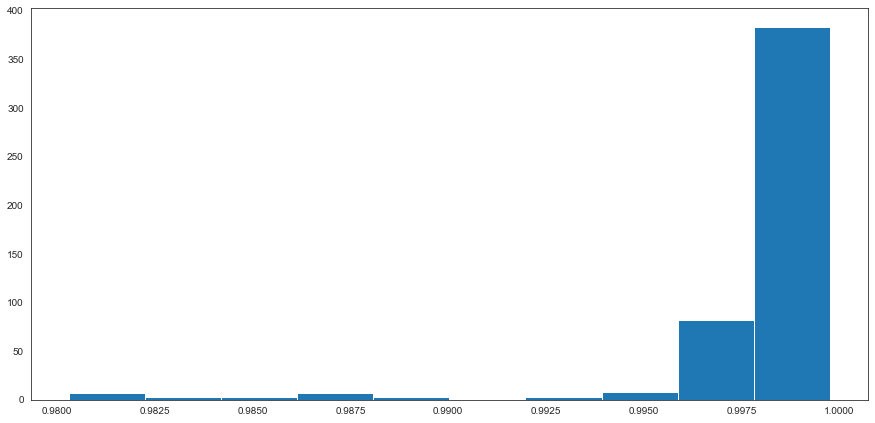

95.0 confidence interval 98.6% and 100.0%


In [58]:
# plot scores
plt.figure(figsize = (15, 7.2))
plt.hist(stats); plt.show()

# confidence intervals
alpha = 0.95 # for 95% confidence 
p = ((1.0 - alpha) / 2.0) * 100 # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats, p))  

p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(stats, p))

print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [59]:
display(df)

,r2 Scores Train,r2 Scores Val,r2 Scores Test
5-Fold LinearRegression,0.7857,0.7748,0.6666
5-Fold LassoRegression,0.7803,0.7698,0.6715
5-Fold RidgeRegression,0.7857,0.7748,0.6666
5-Fold DecisionTree,0.9966,0.8081,0.7314
5-Fold DecisionTree GridSearchCV,0.9824,0.8155,0.7344
5-Fold DecisionTree RandomizedSearchCV,0.9824,0.8155,0.7344
5-Fold RandomForest,0.9839,0.9075,0.8727
5-Fold RandomForest GridSearchCV,0.9846,0.9075,0.8739
5-Fold RandomForest RandomizedSearchCV,0.9821,0.8944,0.8706
5-Fold AdaBoost,0.8307,0.7939,0.7119


* In the feature engineering stage, we identified opportunities to add features based on variable interaction and gaussians but ended up adding multicollinearity in the data.
* Used methods such as model based feature importance, eli5, correlation matrix, absolute correlation and variance inflation factor to understand important attributes.
* Used cross validation method to compare linear and non-linear/tree-based models on training and validation sets. Here it was also important to check and see if there's any improvement after feature engineering. We found a significant improvement in the R2 scores (which was chosen as an evaluation criterion for the study) after performing exploratory data analysis and feature engineering steps.
* Here we tried **3 linear regressions (Linear, Lasso and Ridge) and decision tree-based regression methods such as Decision Tree, Random Forest, AdaBoost, Gradient Boost and Extra Trees regressor**. We used **k-Fold cross validation, grid search and random search methods** to squeeze out the extra performance from the regressors. For some it resulted an improvement while for some it didn't owing to the limited hyperparameter space.
* Used Bootstrapping method to calculate confidence intervals for Gradient Boost Regressor and found a 95% likelihood of r2 score between 97% and 100% for Gradient Boost Regressor.